규제 선형회귀(Regularized Linear Regression)
- 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어 해야 함
- 최적 모델을 위한 Cost 함수 구성요소 = 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어
  - 비용 함수 목표 = $Min(RSS(W)+alpha*||W||_2^2)$

- alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
  - alpha가 0(또는 매우 작은값)이라면 비용함수식은 기존과 동일한 $Min(RSS(W)+0)$
  - 반면 alpha가 무한대(또는 매우 큰값)라면 비용함수식은 RSS(W)에 비해 $alpha*||W||_2^2$ 값이 너무 커지게 되므로 W값을 0(또는 매우작게)으로 만들어야 Cost가 최소화 되는 비용 함수 목표를 달성할 수 있음
  - 즉, alpha값을 크게 하면 비용함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며 alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음

- alpha = 0인 경우는 W가 커도 $alpha * ||W||_2^2$가 0이 되어 비용함수는 $Min(RSS(W))$
- alpha = 무한대 인 경우 $alpha * ||W||_2^2$도 무한대가 되므로 비용 함수는 W를 0에 가깝게 최소화 해야 함

규제 선형 회귀의 유형
- 비용함수에 alpha값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regularization)라고 함
- L2 규제
  - $alpha * ||W||_2^2$와 같이 w의 제곱에 대해 페널티를 부여하는 방식. 릿지(Ridge) 회귀
- L1 규제
  - $alpha * ||W||_1$와 같이 w의 절대값에 대해 페널티를 부여하는 방식. 라쏘(Lasso) 회귀. L1규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환함
- ElasticNet : L2, L1 규제를 함께 결합한 모델. 주로 피처가 많은 데이터 세트에서 적용되며, L1규제로 피처의 개수를 줄임과 동시에 L2규제로 계수 값의 크기를 조정함

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target

In [0]:
from sklearn.model_selection import train_test_split

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

Ridge Regression

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE:{0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE:5.518


In [4]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0, 0.1, 1, 10, 100]

# alpha list 값을 iteration 하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788
alpha 1 일 때 5 folds의 평균 RMSE : 5.653
alpha 10 일 때 5 folds의 평균 RMSE : 5.518
alpha 100 일 때 5 folds의 평균 RMSE : 5.330


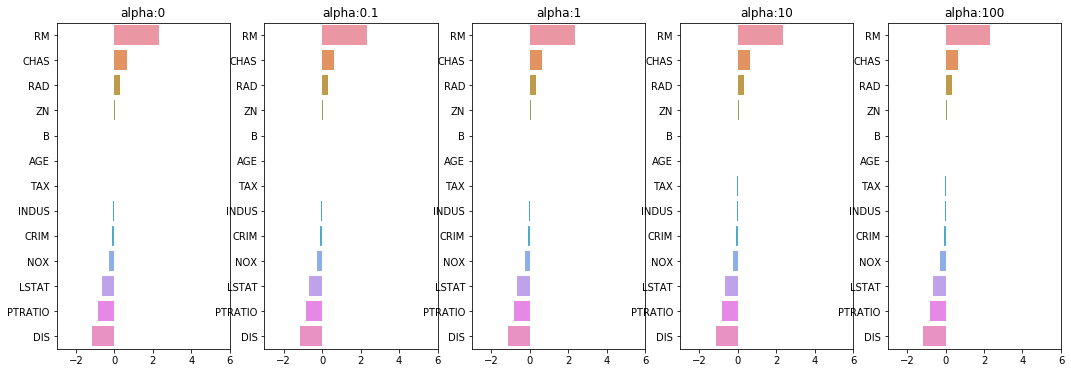

In [5]:
# 각 alpha에 따른 회귀 계수 값을 시각화 하기 위해 5개의 열로 된 matplotlib 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alpha 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
  coeff = pd.Series(data = ridge.coef_, index=X_data.columns)
  colname='alpha:' + str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha 값에서는 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [6]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,2.334536,2.334536,2.334536,2.334536,2.334536
CHAS,0.638335,0.638335,0.638335,0.638335,0.638335
RAD,0.315358,0.315358,0.315358,0.315358,0.315358
ZN,0.054496,0.054496,0.054496,0.054496,0.054496
B,0.009393,0.009393,0.009393,0.009393,0.009393
AGE,0.001212,0.001212,0.001212,0.001212,0.001212
TAX,-0.015856,-0.015856,-0.015856,-0.015856,-0.015856
INDUS,-0.052826,-0.052826,-0.052826,-0.052826,-0.052826
CRIM,-0.102202,-0.102202,-0.102202,-0.102202,-0.102202
NOX,-0.262847,-0.262847,-0.262847,-0.262847,-0.262847


라쏘(Lasso) 회귀
- W의 절대값에 페널티를 부여하는 L1규제를 선형 회귀에 적용한 것
- $alpha * ||W||_1$를 의미하며, 목표는 $RSS(W) + alpha * ||W||_1$ 식을 최소화 하는 W를 찾는 것. L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
  - L1 규제는 적절한 피처만 회귀에 포함시키는 피처 셀렉션의 특성을 가짐

엘라스틱넷(Elastic Net) 회귀
- L2규제와 L1규제를 결합한 회귀
  - 비용함수의 목표는 $RSS(W) + alpha * ||W||_2^2 + alpha * ||W||_1$ 식을 최소화 하는 w를 찾는 것
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함. 이런 성향으로 인해 alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수도 있는데, 이를 완화 하기 위해 L2 규제를 라쏘 회귀에 추가한 것
- ElasticNet 클래스 주요 생성 파라미터
  - 규제는 a L1규제 + b L2규제로 정의될 수 있음
  - alpha 파라미터
    - 이때 a는 L1 규제의 alpha값, b는 L2 규제의 alpha 값
    - ElasticNet 클래스의 alpha 파라미터 값은 a+b
  - l1_ratio 파라미터
    - a / (a + b)
    - l1_ratio가 0이면 a가 0이므로 L2 규제와 동일
    - l1_ratio가 1이면 b가 0이므로 L1 규제와 동일
    - 0 < l1_ratio < 1이며 L1과 L2규제를 함께 적절히 적용
  - ElasticNet의 alpha가 10, l1_ratio가 0.7이라면, L1_ratio=0.7=a/a+b=4/10이므로 L1 alpha값은 7, L2 alpha 값은 3임

Lasso Regression

In [0]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('###### ', model_name, '######')
  for param in params:
    if model_name == 'Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data, y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
    coeff = pd.Series(data=model.coef_, index=X_data.columns)
    colname='alpha:' + str(param)
    coeff_df[colname] = coeff
  return coeff_df

In [17]:
# Lasso에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

######  Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [18]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


ElasticNet Regression

In [19]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

######  ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [20]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


선형 회귀 모델을 위한 데이터 변환
- 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타겟값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형 함수를 찾아내 결과값을 예측함
- 선형 회귀 모델은 피처값과 타겟값의 분포가 정규분포(즉, 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태) 형태를 매우 선호
- 타겟값 변환 : 회귀에서 타겟값은 반드시 정규 분포를 가져야 함. 이를 위해 주로 로그 변환을 적용.
- 피처값 변환
  - StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환
  - MinMaxScaler 클래스를 이용해 최소값이 0, 최대값이 1인 정규화를 수행
  - 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법
  - 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨. 

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data
  
  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
  return scaled_data

In [22]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]
# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data, y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788